In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from setting.setting import *
import matplotlib.pyplot as plt

In [12]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/CNN"
best_model_filename = "cnn_best_model_v1.pth"
os.makedirs(model_dir, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.9, 1.0)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
    ]),
}

train_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8), 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 26)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [17]:
best_val_acc = 0.0
best_val_loss = float('inf')
patience = 20
loss_no_improve = 0
final_total_epochs = 1000
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(final_total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f'Epoch {epoch+1}/{final_total_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_dir, best_model_filename))
        print('Model saved')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        loss_no_improve = 0
    else:
        loss_no_improve += 1

    if loss_no_improve >= patience:
        print('Early stopping triggered')
        break

Epoch 1/1000, Loss: 1.2939, Accuracy: 0.6226, Val Loss: 0.2377, Val Acc: 0.9436
Model saved
Epoch 2/1000, Loss: 0.5108, Accuracy: 0.8576, Val Loss: 0.1612, Val Acc: 0.9619
Model saved
Epoch 3/1000, Loss: 0.3933, Accuracy: 0.8961, Val Loss: 0.1303, Val Acc: 0.9708
Model saved
Epoch 4/1000, Loss: 0.3382, Accuracy: 0.9101, Val Loss: 0.1256, Val Acc: 0.9712
Model saved
Epoch 5/1000, Loss: 0.3023, Accuracy: 0.9197, Val Loss: 0.1099, Val Acc: 0.9757
Model saved
Epoch 6/1000, Loss: 0.2738, Accuracy: 0.9285, Val Loss: 0.1054, Val Acc: 0.9777
Model saved
Epoch 7/1000, Loss: 0.2576, Accuracy: 0.9323, Val Loss: 0.0971, Val Acc: 0.9769
Epoch 8/1000, Loss: 0.2467, Accuracy: 0.9354, Val Loss: 0.0877, Val Acc: 0.9781
Model saved
Epoch 9/1000, Loss: 0.2342, Accuracy: 0.9378, Val Loss: 0.0838, Val Acc: 0.9789
Model saved
Epoch 10/1000, Loss: 0.2206, Accuracy: 0.9415, Val Loss: 0.0813, Val Acc: 0.9817
Model saved
Epoch 11/1000, Loss: 0.2039, Accuracy: 0.9445, Val Loss: 0.0811, Val Acc: 0.9797
Epoch 12/1

In [18]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/CNN\cnn_best_model_v1.pth


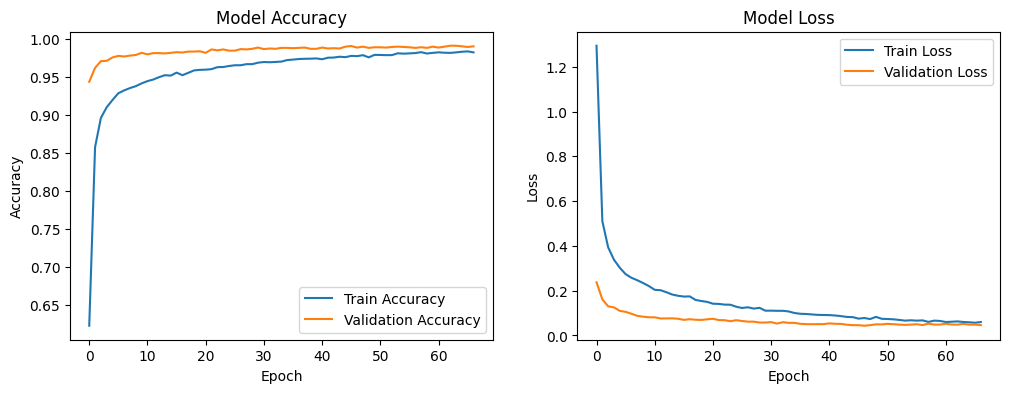

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/CNN\cnn_best_model_v1.pth
